# APPLIED DATA ANALYSIS PROJECT

In [1]:
import pandas as pd
import requests
import re
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from bs4 import BeautifulSoup

In [2]:
URL_QS = 'https://en.wikipedia.org/wiki/List_of_former_European_colonies'
r = requests.get(URL_QS)
soup = BeautifulSoup(r.text, 'lxml')

In [3]:
colonizer_countries = []

# To find the name of all colonizer country of Europe, we take care about 2 things :
#  - If there is more than 2 spaces in the text -> isn't a country
#  - If there is less than 2 letters in the text -> isn't a country

for country in soup.findAll('p'):
    nb_space = sum(c.isspace() for c in country.text)
    
    if country.text not in colonizer_countries and nb_space < 3 and len(country.text) > 2:
        colonizer_countries.append(country.text)

# List Cleaning
colonizer_countries = [country.replace('\n', '') for country in colonizer_countries]

colonizer_countries

['Denmark',
 'France',
 'Netherlands',
 'Norway',
 'Portugal',
 'Russia',
 'Spain',
 'Sweden',
 'Brandenburg',
 'Britain',
 'Courland',
 'Denmark-Norway',
 'Knights of Malta',
 'Belgium',
 'Germany',
 'Italy',
 'Austria',
 'United Kingdom',
 'Germany',
 'Greece']

In [4]:
regions = []

for region in soup.find("ul").findAll('li'):
    regions.append(region.text[2:])

del regions[-1], regions[-1] 

regions

['North America',
 'West Indies and the Caribbean',
 'South America',
 'Africa',
 'Indian Ocean',
 'Middle East',
 'Indian Subcontinent',
 'Asia-Pacific',
 'Europe']

In [5]:
def get_infobox(soup):
    """Get the infobox of a wikipedia page (infobox contains all important informations)."""

    infobox = soup.find("table", class_="infobox geography")
    if not infobox: infobox = soup.find("table", class_="infobox geography vcard")
    if not infobox: infobox = soup.find("table", class_="infobox geography vcard vevent")
    if not infobox: infobox = soup.find("table", class_="infobox vcard ")
    if not infobox: return False
    
    return infobox.extract()


def get_colonizer_and_decoloniz_date(infobox, colonizer):
    """Get the colonizer country and the date of independence of a ex-colony"""

    new_colonizer, independ_date = np.nan, np.nan

    if infobox:
        formation = infobox.find_next(text = re.compile("Formation"))

        if formation: 
            independence = formation.find_next(text = re.compile("independence")) 

            if independence:
                if independence.find_next("a"): new_colonizer = independence.find_next("a").text
                if independence.find_next("td"): independ_date = get_data_cleaned(independence.find_next("td"))

            else:
                independence = formation.find_next(text = re.compile("Independence"))

                if independence:
                    new_colonizer = independence.find_next("a").text
                    independ_date = get_data_cleaned(independence.find_next("td"))
                else:
                    independ_date = get_data_cleaned(formation.find_next("td"))

        else:
            independence = infobox.find_next(text = re.compile("Independence"))

            if independence:
                new_colonizer = independence.find_next("a").text
                independ_date = get_data_cleaned(independence.find_next("td"))

                independence_next = independence.find_next(text = re.compile("Independence"))

                if independence_next:
                    independ_date = get_data_cleaned(independence_next.find_next("td"))
                else: 
                    independence_next = independence.find_next(text = re.compile("Declared"))

                    if independence_next:
                        independ_date = get_data_cleaned(independence_next.find_next("td"))
                        
        if new_colonizer in colonizer_countries:
            return new_colonizer, independ_date
        else:
            return colonizer, independ_date
    
    
def get_data_cleaned(independ_date):
    """Transforme the independence date from wikipedia to a usable date"""
    
    month = {'January': '01', 'February': '02', 'March': '03', 
             'April': '04', 'May': '05', 'June': '06',  'July': '07', 
             'August': '08', 'September': '09', 'October': '10',  
             'November': '11', 'December': '12'}
  
    if independ_date:
        if not type(independ_date) == 'str':
            independ_date_tmp = independ_date.text.split()
        else:
            independ_date_tmp = independ_date.split()

        if len(independ_date_tmp) >= 3:
            if independ_date_tmp[1] in month:
                independ_date_tmp = independ_date_tmp[0] + '/' + month[independ_date_tmp[1]] + "/" + independ_date_tmp[2]
                independ_date_cleaned = independ_date_tmp.split('[')[0]
                return independ_date_cleaned

            elif independ_date_tmp[0] in month:
                independ_date_tmp = independ_date_tmp[1].split(',')[0]  + '/' + month[independ_date_tmp[0]] + "/" + independ_date_tmp[2]
                independ_date_cleaned = independ_date_tmp.split('[')[0]            
                return independ_date_cleaned

    return np.nan


def get_ID(infobox):
    """Get ID (ISO 3166 code) of the country"""

    ID = infobox.find(text = re.compile("ISO 3166 code"))
    
    if ID is not None:
        return ID.find_next('a').text
    else:
        return False

    
def get_size(infobox):
    """Get size of the country"""
    
    area = infobox.find("th", text="Area")
    
    if area:
        size = area.parent.next_sibling.next_sibling.td.text.split("\xa0")[0]

        # Size cleaning
        if '–' in size: size = size.split("–")[0]
        if '[' in size: size = size.split("[")[0]
        if ',' in size: size = size.replace(",", "")
        if '.' in size: size = size.split(".")[0]
        if ' ' in size: size = size.split(" ")[0]                                       
        if len(size) == 0: size = 0
            
        return int(size)
    
    else:
        return 0

    
def get_succeeded_by(infobox):
    """Get new countries who succeed to a ex-colony"""
    
    succeeded_by = infobox.find("b", text="Succeeded by")
    
    if succeeded_by: 
        succeeded_by = succeeded_by.parent.parent.next_sibling.next_sibling

        new_country = succeeded_by.find(style="border:0; padding:0; vertical-align:middle; text-align:right;").text
        URL = succeeded_by.find(style="border:0; padding:0; vertical-align:middle; text-align:right;").a['href']

        return new_country, URL

    else:
        return False, False
 

def get_today_part_of(infobox):
    """Get all new countries formed by a ex-colony"""

    new_countries, URL, i = [], [], 0
     
    today_part_of = infobox.find("b", text="Today part of")
    
    if today_part_of: 
        today_part_of = today_part_of.find_all_next("a")
       
        # Naviguate in all "today part of" country
        while is_a_country(today_part_of[i]) and i < 5 and i < len(today_part_of) - 1:
            if today_part_of[i].has_attr('href'):
                new_countries.append(today_part_of[i].text)
                URL.append(today_part_of[i]['href'])
            i += 1
            
        return new_countries, URL

    else:
        return False, False

    
def is_a_country(info):
    """ Check if the country is realy a country"""
    
    if info.has_attr('href'):
        if info['href'].split('/')[0] is '':
            return True
        else:
            return False
    else:
        return False


In [6]:
def check_country(df, colonized, colonizer, URL, nb_check):
    
    # The checking of each colony is as follows :
    # - If a infobox (the resum on the right side) exist, we check the size. If the size is inferior than a 
    #   certain value, we does not considere this country because it is more a island or a city than a country.
    #   We also check if the colonizer country is the same at the end as the begin. And the end, we take the 
    #   colonizer country juste before the independance.
    # - If a word like 'disestablished' or 'disestablishments' is found in the page, we considere that the
    #   country don't exist any more. We check if a new country was created on find 
    #   the sentence "Succeeded by" in the infobox (if it extist) and repeat the checking with the new 
    #   country if found
    
    if nb_check > 4 or colonized in colonizer_countries:
        return
    
    URL_QS = 'https://en.wikipedia.org' + URL
    r = requests.get(URL_QS)
    soup = BeautifulSoup(r.text, 'lxml')

    infobox = get_infobox(soup) 
    
    new_countries, new_URL = [], []
    
    if infobox:
        
        # Check if it's not a region of a country
        if not infobox.find("th", text="Country"):
        
            # Check if the country still exist
            if not soup(text=re.compile('disestablished')) and not soup(text=re.compile('disestablishments')): 
                size = get_size(infobox)

                # If the country size is inferior to 1'500 km2, don't care of it
                if size > 1500:
                    ID = get_ID(infobox)
                    colonizer, independ_date = get_colonizer_and_decoloniz_date(infobox, colonizer)

                    # Check if the colonized country is not a duplicate
                    if len(df[df['ID']== ID]) < 1:
                        df.loc[len(df)+1] = [colonized, ID, independ_date, colonizer, URL]
            else:
                # If the country don't exist anymore, check the new countries in the "today part of" channel 
                new_countries, new_URL = get_today_part_of(infobox)

                if new_countries:
                    for index, country in (enumerate(new_countries)):
                        check_country(df, country, colonizer, new_URL[index], nb_check + 1) 

                else:
                    # If  channel "today part of" don't exist, check the new countries in the "get succeeded by" 
                    # channel 
                    new_country, new_URL = get_succeeded_by(infobox)

                    if new_country:
                        check_country(df, new_country, colonizer, new_URL, nb_check + 1)

In [7]:
# Dataframe creation
colonization_df = pd.DataFrame(columns=['Colonized Country', 'ID', 'Date', 'Colonizer Country', "URL"])

URL_QS = 'https://en.wikipedia.org/wiki/List_of_former_European_colonies'
r = requests.get(URL_QS)
soup = BeautifulSoup(r.text, 'lxml')

for colonizer_country in colonizer_countries:
    #colonizer_country = "Russia"# colonizer_countries[6]
    print(colonizer_country, "...")

    # Trouve tout les emplacements où on fait mention du pays "colonizer"
    colonizer_index = soup.find_all("p", text=colonizer_country) 

    for i in range (len(colonizer_index)):
        colonized_countries = colonizer_index[i].next_sibling.next_sibling('a')

        for colonized_country in colonized_countries:
             if colonized_country.text not in regions and len(colonized_country.attrs) < 3:
                check_country(colonization_df, colonized_country.text, colonizer_country, colonized_country['href'], 1)

colonization_df

Denmark ...
France ...
Netherlands ...
Norway ...
Portugal ...
Russia ...
Spain ...
Sweden ...
Brandenburg ...
Britain ...
Courland ...
Denmark-Norway ...
Knights of Malta ...
Belgium ...
Germany ...
Italy ...
Austria ...
United Kingdom ...
Germany ...
Greece ...


,Colonized Country,ID,Date,Colonizer Country,URL
1,Greenland,GL,NaN,Denmark,/wiki/Greenland
2,Iceland,IS,NaN,Denmark,/wiki/Iceland
3,Canada,CA,1/07/1867,United Kingdom,/wiki/Canada
4,United States,US,4/07/1776,France,/wiki/United_States
5,Haiti,HT,1/01/1804,France,/wiki/Haiti
6,Benin,BJ,1/08/1960,France,/wiki/Benin
7,Cameroon,CM,1/01/1960,France,/wiki/Cameroon
8,Chad,TD,11/08/1960,France,/wiki/Chad
9,Republic of the Congo,CG,15/08/1960,France,/wiki/Republic_of_the_Congo
10,Central African Republic,CF,13/08/1960,France,/wiki/Central_African_Republic


In [8]:
# Dataset cleaning

colonization_df_cleaned = colonization_df.replace("Britain", "United Kingdom")

colonization_df_cleaned.to_csv("datasets/colonies_wikipedia.csv")

United Kingdom    49
France            26
Spain             15
Russia            13
Portugal           6
Netherlands        6
Italy              3
Belgium            3
Denmark            2
Name: Colonizer Country, dtype: int64


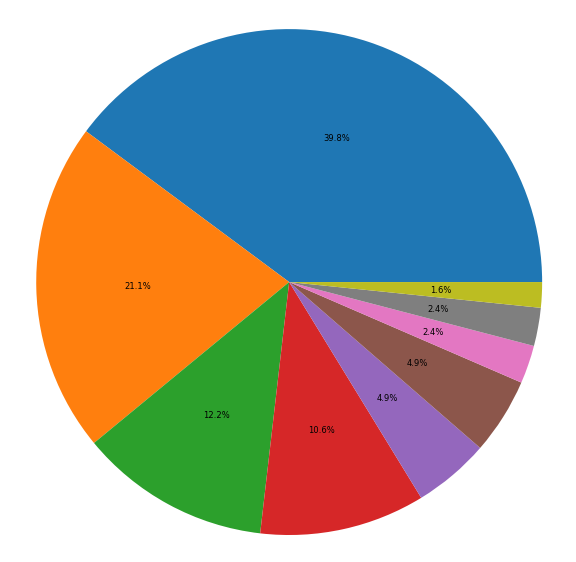

In [9]:
print(colonization_df_cleaned['Colonizer Country'].value_counts())

plt.figure(figsize=(12,12), dpi=60, facecolor='w', edgecolor='k')
plt.pie(colonization_df_cleaned['Colonizer Country'].value_counts(), autopct = '%1.1f%%')
plt.axis('equal');

In [10]:
# TO DO
# - Cleaner le dataset